In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_curve, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.svm import SVC, OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from matplotlib import style
from tensorflow import keras, feature_column
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn import metrics
from tensorboard import notebook

# **Synthaxe pour visualiser l'entièreté de mon Dataset**

In [2]:
pd.set_option('display.max_row', 79)
pd.set_option('display.max_column', 79)

# **Chargement du Dataset & copie dans un dataframe**

In [3]:
data = pd.read_csv('ids2018.csv')

In [4]:
df = data.copy()

In [5]:
df.shape

(1252846, 79)

# **Prise en charge des données manquantes, suppression des doublons**

In [6]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(df.duplicated().sum())

117437


In [7]:
df.drop_duplicates(inplace = True)
print(df.duplicated().sum())

0


# **Mise en œuvre de la classification binaire**

In [8]:
old_value = 1
new_value = 0
df['Label'] = df['Label'].replace(old_value, new_value)

In [9]:
for i in range(2, 12):
    old_value = i
    new_value = 1
    df['Label'] = df['Label'].replace(old_value, new_value)

In [10]:
labels_dict = {
    0: 'Benign',
    1: 'Anormal'
}
df['Label'] = [labels_dict[item] for item in df['Label']]

In [11]:
encoder = LabelEncoder()

In [12]:
encoder.fit(df['Label'])

LabelEncoder()

In [13]:
filtered_labels = [label for label in df['Label'] if label in encoder.classes_]

In [14]:
decoded_labels = encoder.inverse_transform(encoder.transform(filtered_labels))

In [15]:
decoded_labels

array(['Benign', 'Benign', 'Benign', ..., 'Benign', 'Benign', 'Benign'],
      dtype=object)

In [16]:
label_dict = {
    'Benign': 0,
    'Anormal': 1
}
df['Label'] = [label_dict[item] for item in df['Label']]

# **Équilibrer les données (sous-échantillonnage)**

In [17]:
benign_df = df[df['Label'] == 0][:50000]
anormal_df = df[df['Label'] == 1][:50000]


In [18]:
df = pd.concat([benign_df, anormal_df], axis=0)

In [19]:
df.shape

(100000, 79)

In [ ]:
attaque, counts = np.unique(df['Label'], return_counts=True)
couleurs = ['green', 'red']

Text(0.5, 1.0, 'Répartition des classes')

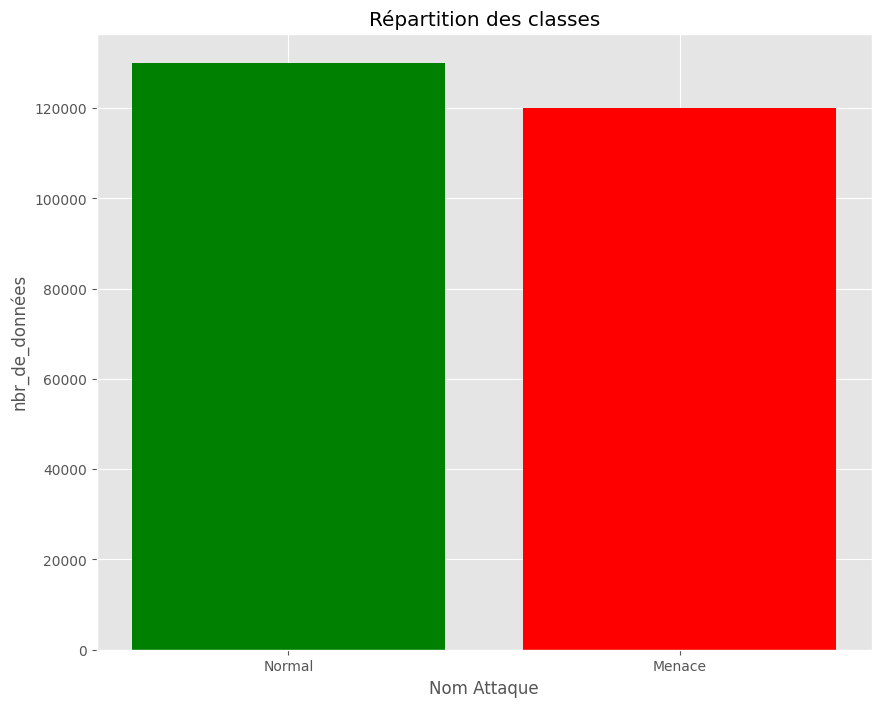

In [ ]:
style.use('ggplot')
plt.figure(figsize=(10, 8))
plt.bar(attaque, counts, color=couleurs)
plt.xticks(attaque, ['Normal', 'Menace'])
plt.xlabel('Nom Attaque')
plt.ylabel('nbr_de_données')
plt.title('Répartition des classes')


# **Suppression des features inutiles**

In [20]:
df = df.drop(['Unnamed: 0', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'FIN Flag Cnt', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Std','Idle Std', 'Flow Pkts/s', 'Fwd IAT Tot', 'Bwd IAT Tot'], axis=1)

# **Creating train/test split**

In [21]:
trainset, testset = train_test_split(df, test_size=0.3, random_state=0)

# **Feature scaling**

In [22]:
trainset.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean',
       'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Mean', 'Fwd IAT Mean',
       'Bwd IAT Mean', 'Fwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Active Mean',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min',
       'Label'],
      dtype='object')

In [23]:
min_max_scaler = MinMaxScaler().fit(trainset[['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean',
       'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Mean', 'Fwd IAT Mean',
       'Bwd IAT Mean', 'Fwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Active Mean',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']])

In [24]:
numerical_columns = ['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean',
       'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Mean', 'Fwd IAT Mean',
       'Bwd IAT Mean', 'Fwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Active Mean',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min',]

In [25]:
trainset[numerical_columns] = min_max_scaler.transform(trainset[numerical_columns])

In [26]:
testset[numerical_columns] = min_max_scaler.transform(testset[numerical_columns])

# **Création des variables X / y**

In [27]:
def preproc(df):
  X = df.drop('Label', axis=1)
  y = df['Label']

  print(y.value_counts())

  return X, y

In [28]:
X_train, y_train = preproc(trainset)

0    35091
1    34909
Name: Label, dtype: int64


In [29]:
X_test, y_test = preproc(testset)

1    15091
0    14909
Name: Label, dtype: int64


# **MODELE DE RESEAU DE NEURONNE**



**Initialisation des paramètres du modèle**

In [30]:
model_1 = tf.keras.Sequential([
    keras.layers.Flatten(input_shape=(33,)),
    keras.layers.Dense(104, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

In [31]:
model_1.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 33)                0         
                                                                 
 dense (Dense)               (None, 104)               3536      
                                                                 
 dense_1 (Dense)             (None, 64)                6720      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 10,386
Trainable params: 10,386
Non-trainable params: 0
_________________________________________________________________


**entrainement du modèle**

In [33]:
history = model_1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
test_loss, test_acc = model_1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/10
2188/2188 [==============================] - 5s 2ms/step - loss: 0.2224 - accuracy: 0.9205 - val_loss: 0.1517 - val_accuracy: 0.9534
Epoch 2/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.1154 - accuracy: 0.9622 - val_loss: 0.0922 - val_accuracy: 0.9639
Epoch 3/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0766 - accuracy: 0.9745 - val_loss: 0.0501 - val_accuracy: 0.9865
Epoch 4/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0504 - accuracy: 0.9864 - val_loss: 0.0644 - val_accuracy: 0.9895
Epoch 5/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0446 - accuracy: 0.9883 - val_loss: 0.0329 - val_accuracy: 0.9908
Epoch 6/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0373 - accuracy: 0.9901 - val_loss: 0.0326 - val_accuracy: 0.9918
Epoch 7/10
2188/2188 [==============================] - 5s 2ms/step - loss: 0.0336 - accuracy: 0.9910 - val_loss: 0.0369 - val_accuracy:

In [34]:
print('Test perte:', test_loss)

Test perte: 0.027735160663723946


In [35]:
y_pred_probs = model_1.predict(X_test)
y_pred_rna = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred_rna)

938/938 [==============================] - 1s 1ms/step


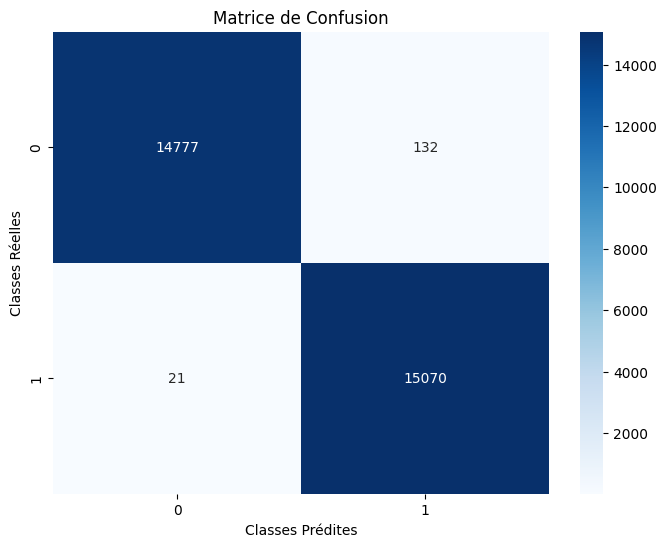

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Classes Prédites')
plt.ylabel('Classes Réelles')
plt.show()

**Visualisation de la fonction perte**





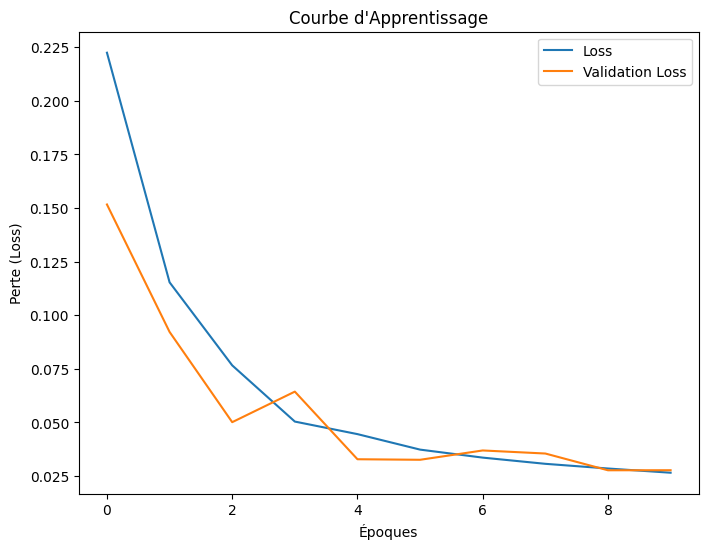

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe d\'Apprentissage')
plt.xlabel('Époques')
plt.ylabel('Perte (Loss)')
plt.legend()
plt.show()

**perfomance des metriques**

In [ ]:
print(classification_report(y_test, y_pred_rna))


              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     14909
         1.0       0.99      1.00      0.99     15091

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



# **Modèle RF, ADA, SVM**

In [51]:
def evaluation(model):

  model.fit(X_train, y_train)
  ypred = model.predict(X_test)

  print(confusion_matrix(y_test, ypred))
  print(classification_report(y_test, ypred))

  N, train_score, val_score = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1, 15))
  plt.figure(figsize=(12,8))
  plt.plot(N, train_score.mean(axis=1), label='train score')
  plt.plot(N, val_score.mean(axis=1), label='validation score')
  plt.legend()

  return model


In [52]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=5))

In [53]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(kernel="rbf", random_state=0))
#KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

# **Amélioration des performance du SVM**

**Liste des hyper-paramètres**

In [54]:
hyper_params = {'svc__C': [0.1, 0.5, 1],
                'svc__gamma': [0.1, 1, 10],
                }

**Initialisation grille d'apprentissage & entrainement et évaluation du modèle**

In [55]:
grid_1 = RandomizedSearchCV(SVM, param_distributions=hyper_params, cv=4, n_iter=8)

In [56]:
grid_1.fit(X_train, y_train)
print(grid_1.best_params_)
y_pred = grid_1.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [391 392 490 491 505 506 518] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [391 392 490 491 505 506 518] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [391 392 490 491 505 506 518] are constant.
  warnings.w

{'svc__gamma': 10, 'svc__C': 1}
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     14909
           1       0.80      0.99      0.89     15091

    accuracy                           0.87     30000
   macro avg       0.89      0.87      0.87     30000
weighted avg       0.89      0.87      0.87     30000



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [391 392 490 491 505 506 518] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[[11208  3701]
 [  170 14921]]
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     14909
           1       0.80      0.99      0.89     15091

    accuracy                           0.87     30000
   macro avg       0.89      0.87      0.87     30000
weighted avg       0.89      0.87      0.87     30000



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [233 284 391 392 490 491 505 506 517 518 542] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [233 284 391 392 490 491 505 506 518 542] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [233 284 391 392 490 491 505

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest(k=5))])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, gamma=10, random_state=0))])

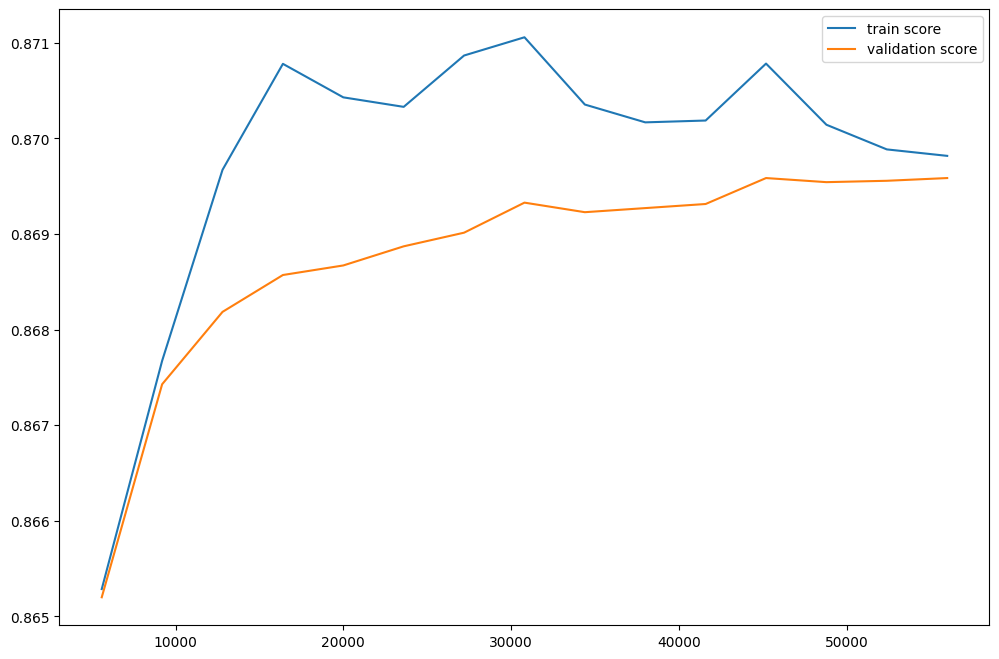

In [57]:
evaluation(grid_1.best_estimator_)

**Seuil de décision**

In [58]:
precision, recall, threshold = precision_recall_curve(y_test, grid_1.best_estimator_.decision_function(X_test))

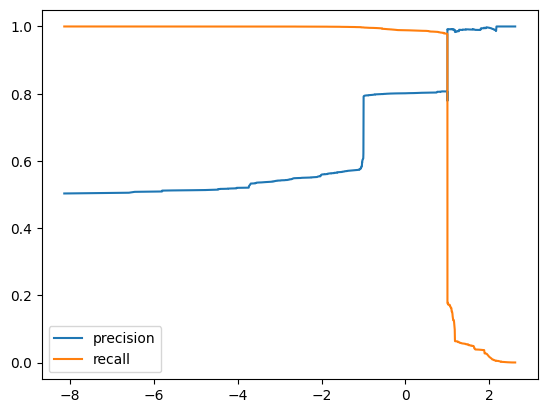

In [59]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [60]:
def model_final(model, X, threshold=0):
  return model.decision_function(X) > threshold

In [61]:
y_pred = model_final(grid_1.best_estimator_, X_test, threshold=1)

**evaluation des perfomances sur le testset**

In [62]:
f1_score(y_test, y_pred)

0.8294904818747252

In [63]:
recall_score(y_test, y_pred)

0.8748923199257835

In [64]:
metrics.accuracy_score(y_test, y_pred)

0.8190666666666667

## **Amelioration de la perfomance du RF**

**Liste des hyper-paramètres**

In [ ]:
hyper_params = {'randomforestclassifier__n_estimators': [50, 100, 150], 'randomforestclassifier__max_depth': [None, 5, 10], 'randomforestclassifier__min_samples_split': [2, 5, 10],
              'randomforestclassifier__min_samples_leaf': [1, 2, 4], 'randomforestclassifier__max_features': ['sqrt', 'log2', None]}

**Initialisation grille & entrainement et évaluation du modèle**

In [ ]:
grid_2 = RandomizedSearchCV(RandomForest, param_distributions=hyper_params, cv=5, n_iter=10, n_jobs=-1)

In [ ]:
grid_2.fit(X_train, y_train)
print(grid_2.best_params_)
y_pred = grid_2.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [391 392 490 491 505 506 518] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


{'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': None}
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     14909
           1       0.82      1.00      0.90     15091

    accuracy                           0.89     30000
   macro avg       0.91      0.89      0.89     30000
weighted avg       0.91      0.89      0.89     30000



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [391 392 490 491 505 506 518] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[[11714  3195]
 [   51 15040]]
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     14909
           1       0.82      1.00      0.90     15091

    accuracy                           0.89     30000
   macro avg       0.91      0.89      0.89     30000
weighted avg       0.91      0.89      0.89     30000



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [233 284 391 392 490 491 505 506 517 518 542] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [233 284 391 392 490 491 505 506 518 542] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [233 284 391 392 490 491 505

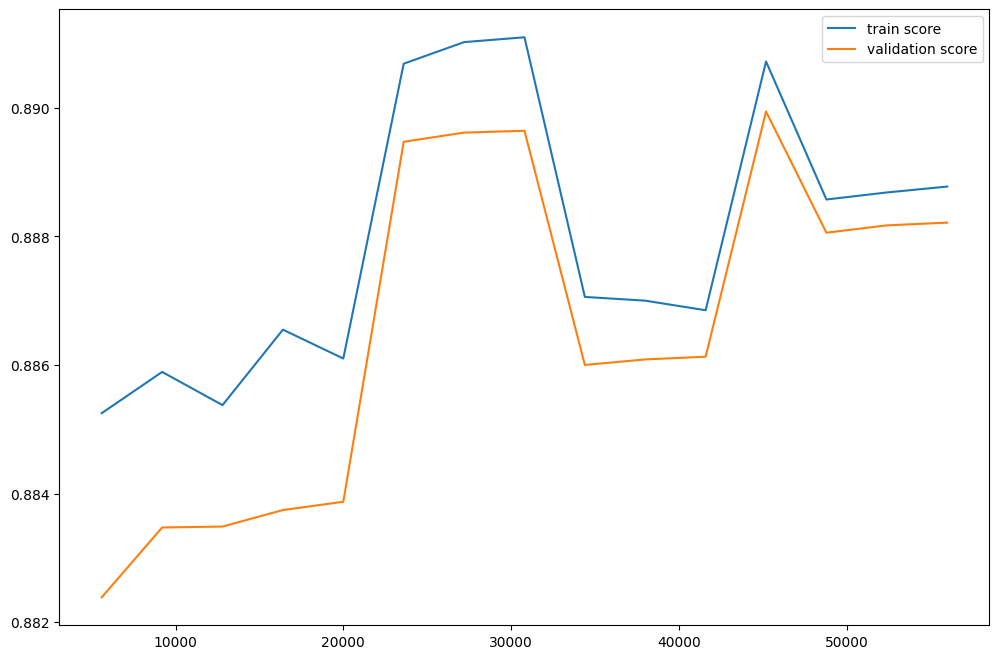

In [ ]:
best_rf = evaluation(grid_2.best_estimator_)

In [ ]:
best_rf.fit(X_train, y_train)

# Predicting Train & Test Results
y_rf = best_rf.predict(X_train)
y_pred_rf = best_rf.predict(X_test)

# Accuracy
print("Accuracy on Training set: ",metrics.accuracy_score(y_train, y_rf))
print("Accuracy on Testing set: ",metrics.accuracy_score(y_test, y_pred_rf))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [391 392 490 491 505 506 518] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Accuracy on Training set:  0.8923857142857143
Accuracy on Testing set:  0.8918


# **Modèle KNN**

**Entrainement et évaluation du modèle**

In [38]:
#creation du modèle
model_3 = KNeighborsClassifier()
model_3.fit(X_train, y_train) #entrainer le modèle avec le trainset
print('Score test : ', model_3.score(X_test, y_test)) # évaluation du modèle

Score test :  0.9960333333333333


In [39]:
cross_val_score(model_3, X_train, y_train, cv=5, scoring='accuracy').mean()

0.9956714285714285

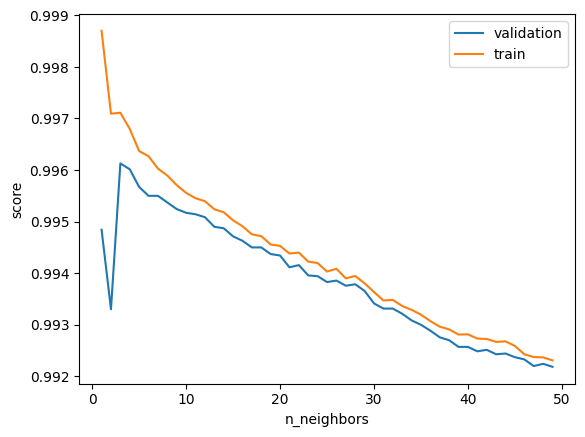

In [40]:
k = np.arange(1, 50)
train_score, val_score = validation_curve(model_3, X_train, y_train, param_name='n_neighbors', param_range=k, cv=5)
plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.legend()


In [41]:
model_3.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [42]:
params_grid = {
    'n_neighbors': np.arange(1, 25),
    'metric':['euclidean', 'manhattan']
}

grid_3 = GridSearchCV(KNeighborsClassifier(), params_grid, cv=5)
grid_3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [43]:
print(grid_3.best_score_)
print(grid_3.best_params_)
model_3 = grid_3.best_estimator_
model_3.score(X_test, y_test)

0.9963714285714286
{'metric': 'manhattan', 'n_neighbors': 3}


0.9962333333333333

In [44]:
print(model_3.get_params())
y_pred_knn = model_3.predict(X_test)
confusion_matrix(y_test, y_pred_knn)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}


array([[14825,    84],
       [   29, 15062]])

In [45]:
M, train_score, val_score = learning_curve(model_3, X_train, y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5)
print(M)

[ 5600 11200 16800 22400 28000 33600 39200 44800 50400 56000]


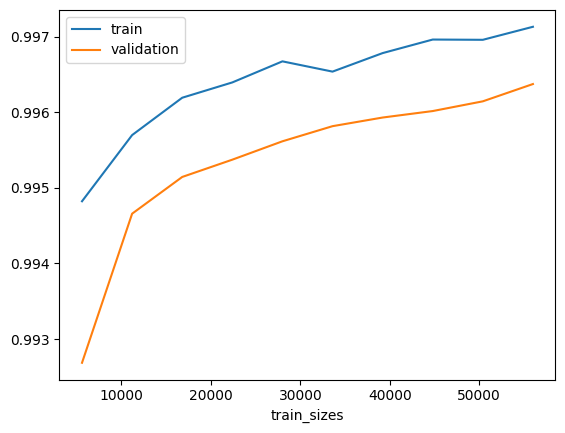

In [46]:
plt.plot(M, train_score.mean(axis=1), label='train')
plt.plot(M, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [47]:
pred = model_3.predict(X_test)
pred

array([0, 1, 1, ..., 0, 0, 0])

In [48]:
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14909
           1       0.99      1.00      1.00     15091

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



In [49]:
pred_decode = encoder.inverse_transform(pred)
pred_decode

array(['Anormal', 'Benign', 'Benign', ..., 'Anormal', 'Anormal',
       'Anormal'], dtype=object)

In [ ]:
for i in range(len(pred_decode)):
  if pred_decode[i]!='Benign':
    print('prediction is', pred_decode[i])

# **Stacking des différents modèle**

**Ensemble de prédiction pour le modèle méta-apprenant**

In [92]:
# Créez un objet TensorBoard pour la visualisation
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

In [76]:
stacked_pred = np.column_stack((y_pred_rna, pred, y_pred,))

**Modèle méta-apprenant avec RNA**

In [78]:
meta_learner_model = tf.keras.Sequential([
    keras.layers.Dense(104, activation='relu', input_shape=(3,)),   # 3 modèles de base utilisés
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [67]:
meta_learner_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 104)               416       
                                                                 
 dense_4 (Dense)             (None, 64)                6720      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________


**Entraînement du modèle méta-apprenant**

In [93]:
meta_learner_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

meta_learner_model.fit(stacked_pred, y_test, epochs=10, batch_size=64, callbacks=[tensorboard])

Epoch 1/10
469/469 [==============================] - 2s 2ms/step - loss: 0.0217 - accuracy: 0.9962
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0216 - accuracy: 0.9962
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0217 - accuracy: 0.9962
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0218 - accuracy: 0.9962
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0217 - accuracy: 0.9962
Epoch 6/10
469/469 [==============================] - 1s 1ms/step - loss: 0.0215 - accuracy: 0.9962
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0216 - accuracy: 0.9961
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0215 - accuracy: 0.9963
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0216 - accuracy: 0.9962
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0216 - accuracy: 0.9961

**Évaluation du modèle méta-apprenant**

In [69]:
meta_pred = meta_learner_model.predict(stacked_pred)
meta_pred = np.round(meta_pred).flatten()

meta_accuracy = accuracy_score(y_test, meta_pred)
print("Précision du modèle méta-apprenant (Stacking avec RNA) :", meta_accuracy)

938/938 [==============================] - 1s 1ms/step
Précision du modèle méta-apprenant (Stacking avec RNA) : 0.9954


**Matrice de confusion**

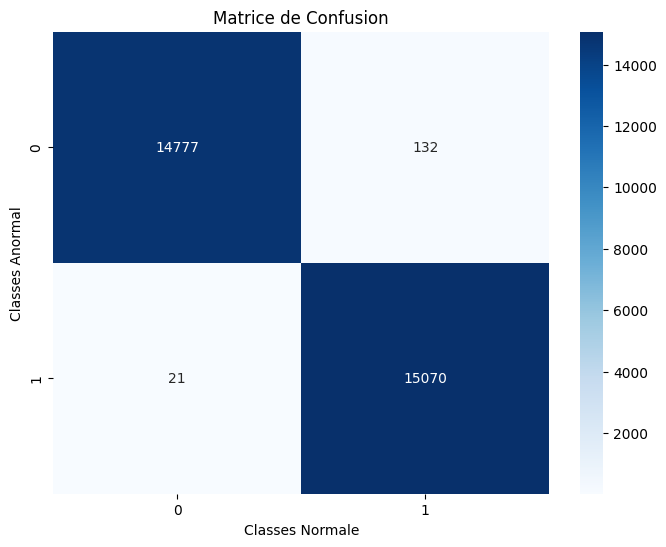

In [70]:
meta_confusion = confusion_matrix(y_test, meta_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Classes Normale')
plt.ylabel('Classes Anormal')
plt.show()

**Visualisation du modèle**

In [ ]:
notebook.start('--logdir ./logs --port 6007')

In [ ]:
!tensorboard --logdir ./logs --port 6009

2023-08-01 16:27:46.188529: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6009/ (Press CTRL+C to quit)


**Dévéloppement de l'API**